## Load the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from nltk import word_tokenize
from functools import lru_cache
import re
import unicodedata
import sys
from collections import Counter
import nltk
nltk.download('brown')
from nltk.corpus import brown
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## First part: The Complex Word Identification Model:

In [ ]:

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

Get the dataset to train the CWI model


In [ ]:
!wget https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip

--2023-05-03 22:37:29--  https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip
Resolving www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)... 134.100.36.5
Connecting to www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)|134.100.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cwishareddataset.zip’

cwishareddataset.zi     [          <=>       ]   1.03M   574KB/s    in 1.8s    

2023-05-03 22:37:32 (574 KB/s) - ‘cwishareddataset.zip’ saved [1075894]



In [ ]:
!unzip cwishareddataset.zip

Archive:  cwishareddataset.zip
   creating: traindevset/
   creating: traindevset/german/
  inflating: traindevset/german/German_Train.tsv  
  inflating: traindevset/german/German_Dev.tsv  
  inflating: traindevset/README.md   
   creating: traindevset/english/
  inflating: traindevset/english/WikiNews_Train.tsv  
  inflating: traindevset/english/Wikipedia_Train.tsv  
  inflating: traindevset/english/Wikipedia_Dev.tsv  
  inflating: traindevset/english/News_Dev.tsv  
  inflating: traindevset/english/News_Train.tsv  
  inflating: traindevset/english/WikiNews_Dev.tsv  
   creating: traindevset/spanish/
  inflating: traindevset/spanish/Spanish_Train.tsv  
  inflating: traindevset/spanish/Spanish_Dev.tsv  
  inflating: README.md               
   creating: testset/
   creating: testset/german/
  inflating: testset/german/German_Test.tsv  
  inflating: testset/README.md       
   creating: testset/english/
  inflating: testset/english/Wikipedia_Test.tsv  
   creating: __MACOSX/
   creating:

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target",
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

Get the glove embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-05-03 22:37:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-03 22:37:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-03 22:37:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip -d embeddings

Archive:  glove.6B.zip
  inflating: embeddings/glove.6B.50d.txt  
  inflating: embeddings/glove.6B.100d.txt  
  inflating: embeddings/glove.6B.200d.txt  
  inflating: embeddings/glove.6B.300d.txt  


Load the embedding model

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))

print(glove_models)

<ipython-input-20-c8d29211e4f3>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x7fa47ca5dcf0>)]


In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    output_file = glove_file + '.word2vec'
    glove2word2vec(glove_file, output_file)

<ipython-input-9-59af8de5c8be>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, output_file)


Process the Dataset in order to formated it:

In [ ]:
dataframe = datasets[0].train[0:30]

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def extract_ngrams_group(group):
    targets = zip(group['target'].values.tolist(), group['start'].values.tolist(),
                 group['end'].values.tolist(), group['binary'].values.tolist())
    for word, start, end, binary in targets:
        tokens = word.split()
        if len(tokens)>1:
            olap_words = [(w, b) for w, s, e, b in targets if overlaps(start, end, s, e)]


grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))

In [ ]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


In [ ]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model.key_to_index)))
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.key_to_index:
            embedding = embedding_model[word]
        else:
             i_ +=1
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row :
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0],
                         'tags': [tag for tag in zip(row['target'],
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob)
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0],
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [ ]:
datasets.append(Dataset('train_all_test_wiki',
        datasets[0].train.append(datasets[1].train).append(datasets[2].train), datasets[0].test))

<ipython-input-13-6c8d08ca5455>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datasets[0].train.append(datasets[1].train).append(datasets[2].train), datasets[0].test))


In [ ]:
# Append train and test set
dataset_sel = datasets[3]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = dataset_sel.train.append(dataset_sel.test)
dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 27299
# Rows test : 694
# Rows dataset : 27993
# Sents train : 1988
# Sents test : 53
# Sents dataset : 2041


<ipython-input-14-fa260ecfaaf6>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset_sel.train.append(dataset_sel.test)


Finally the Dataset to train the model:

In [ ]:
dataset

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
0,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",0,8,Normally,10,10,0,1,1,0.05,1347
1,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",28,34,passed,10,10,0,1,1,0.05,1347
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",15,19,land,10,10,0,0,0,0.00,1347
3,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,49,future,10,10,1,0,1,0.05,1347
4,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,61,future generations,10,10,1,2,1,0.15,1347
...,...,...,...,...,...,...,...,...,...,...,...,...
689,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,100,109,knowledge,10,10,0,2,1,0.10,929
690,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,74,80,person,10,10,0,0,0,0.00,929
691,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,95,99,true,10,10,0,0,0,0.00,929
692,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,113,122,purifying,10,10,7,8,1,0.75,929


In [ ]:
sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]

In [ ]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [ ]:
sentence_lens = [len(sent) for sent in words]

The dimensions of the embedding and vectors for the model:

In [ ]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 96437
# Vocab : 52455
# embeding model  : 400000
# Words missing embedding : 0
Embedding shape : (52455, 300)
i:  9834


## Padding the input sequences and get the binaries labels

In [ ]:

words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 103


# Split the to train and test set


In [ ]:

# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 1988
Test set length : 53


## Create a kera's callback to validate the model on train

In [ ]:
from sklearn.metrics import f1_score
import keras.callbacks
from keras import backend as K
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

## Create the keras model for the Complex Word Identification task

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,BatchNormalization

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm)

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 103)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 103, 300)          15736500  
                                                                 
 dropout_2 (Dropout)         (None, 103, 300)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 103, 300)         541200    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 103, 2)           602       
 tributed)                                                       
                                                                 
Total params: 16,278,302
Trainable params: 16,278,302
Non-t

And Train it:

In [ ]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10,
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)),
                    verbose=1, callbacks=[metrics])

Epoch 1/3
2/2 [==============================] - 1s 85ms/step

F1 Score:
0.05660377358490566
199/199 [==============================] - 187s 855ms/step - loss: 0.0847 - accuracy: 0.9681 - val_loss: 0.0465 - val_accuracy: 0.9786
Epoch 2/3
2/2 [==============================] - 0s 81ms/step

F1 Score:
0.05660377358490566
199/199 [==============================] - 156s 785ms/step - loss: 0.0402 - accuracy: 0.9827 - val_loss: 0.0427 - val_accuracy: 0.9802
Epoch 3/3
2/2 [==============================] - 0s 61ms/step

F1 Score:
0.05660377358490566
199/199 [==============================] - 150s 750ms/step - loss: 0.0300 - accuracy: 0.9873 - val_loss: 0.0453 - val_accuracy: 0.9806


Now let´s plot some chart to see the model performance:

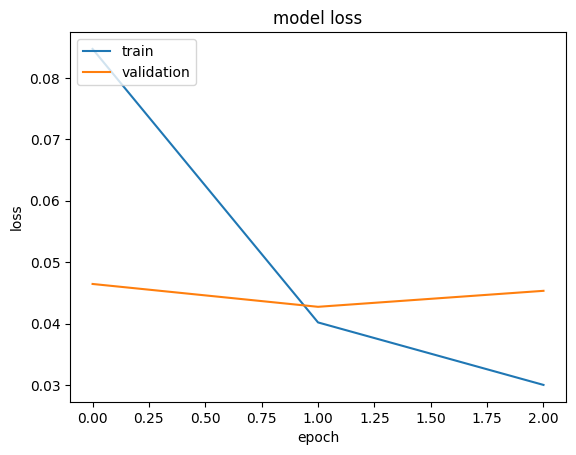

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The F1 Score

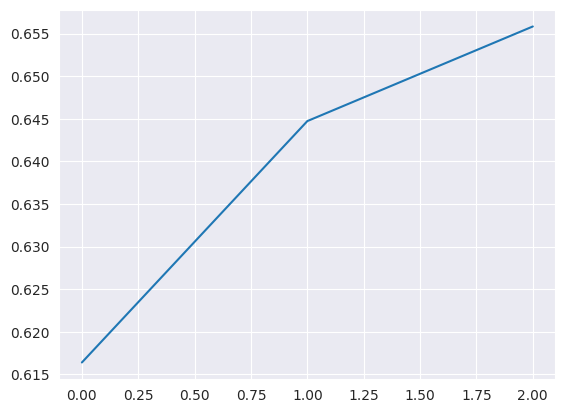

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.05)
in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop1 = Dropout(0.3)(embed)
lstm1 = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop1)
bn1 = BatchNormalization()(lstm1)
drop2 = Dropout(0.5)(bn1)
lstm2 = LSTM(units=150, return_sequences=True, recurrent_dropout=0.1)(drop2)
bn2 = BatchNormalization()(lstm2)
out = TimeDistributed(Dense(2, activation="softmax"))(bn2)

model = Model(in_seq, out)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 103)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 103, 300)          15736500  
                                                                 
 dropout_9 (Dropout)         (None, 103, 300)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 103, 300)         541200    
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 103, 300)         1200      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 103, 300)          0   

In [ ]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10,
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)),
                    verbose=1, callbacks=[metrics])

Epoch 1/3
117/199 [================>.............] - ETA: 1:34 - loss: 0.1619 - accuracy: 0.9455

KeyboardInterrupt: ignored

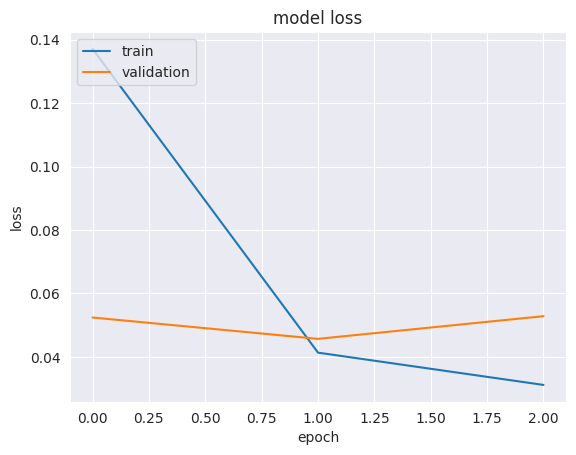

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

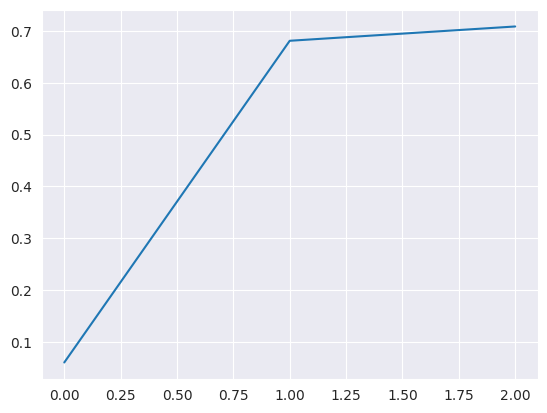

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

## Optional, if you want to save the trained CWI model into your gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_save_name = 'model_CWI_full.h5'
path_dir = F"/content/gdrive/My Drive/{model_save_name}"

Save the model to google drive

In [ ]:
from keras.models import load_model

model.save(path_dir)  # creates a HDF5 file 'model_CWI_full.h5'

Retrieve the model from google drive (if decide to save it)

In [ ]:
from keras.models import load_model

model_cwi = load_model(path_dir)

## Now, let´s define some useful functions in order to use the CWI with some out of samples sentences

Function for clean the data and remove non characters symbols

In [ ]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

Function for to create the padded sequence

In [ ]:

def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)


In [ ]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions


# Second part: The Candidates generation and selection using BERT

First, install the libraries

In [ ]:
!pip install transformers
!pip install torch

Load the BERT  model for masked languge

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

To compute the **Zipf values**, we use the library **wordfreq**

In [ ]:
!pip install wordfreq

if we want the Zipf of the word "stop":

In [ ]:
from wordfreq import zipf_frequency
zipf_frequency('stop', 'en')


and for the word "thwart":

In [ ]:
from wordfreq import zipf_frequency
zipf_frequency('thwart', 'en')

As you can see the word "stop" is the most common.

## Now the function to get the candidates out of BERT (MLM):

In [ ]:
def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 30):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <2.95:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert

# Simplifying new sentences:

Given a list of new sentences with complex words:

In [ ]:
list_texts = [
 'The patient has a fractured clavicle and requires immobilization of the affected area.',
 'The patient has gastroesophageal reflux disease (GERD) and should avoid acidic foods and beverages.',
 'The patient has an acute myocardial infarction (AMI) and requires urgent medical intervention.',
 'The patient has hypertension and needs to take antihypertensive medication to lower their blood pressure.'  ,
 'The patient has a herniated lumbar disc and needs physical therapy to alleviate their back pain.',
 'The patient has a pulmonary embolism and needs anticoagulant medication to prevent blood clots.',
 'The patient has gastroenteritis and needs to stay hydrated and rest to recover.'
]

We apply the simplifier to see how it is performing:

In [ ]:
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    print('word_to_replace : ' , word_to_replace )
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)

  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

**Pretty** **good results**

In [ ]:
# Represent list candidates as a word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Relations = {}
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  list_candidates = []
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    #Extract the list of all high ranked candidates
    high_ranked_candidates = [t[0] for t in tuples_word_zipf if t[1] > 2.95]
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    print('word_to_replace : ' , word_to_replace )
    Relations[word_to_replace] = high_ranked_candidates
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)
    list_candidates.append(tuples_word_zipf[0][0])
  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

# Represent Relations as a word cloud
def word_cloud_relations(Relations):
  #Seperate every key-value pair in the dictionary and represent it as its own word cloud in a grid
    fig, axs = plt.subplots(4, 3, figsize=(15, 10))
    fig.suptitle('Word Clouds of Relations')
    for i, (key, value) in enumerate(Relations.items()):
        wordcloud = WordCloud(width = 1000, height = 500).generate(str(value))
        axs[i//3, i%3].imshow(wordcloud)
        axs[i//3, i%3].set_title(key)
        axs[i//3, i%3].axis("off")
    plt.show()
word_cloud_relations(Relations)
